In [3]:
import pandas as pd 
import numpy as np 
from random import sample 
from sklearn.utils import resample  
import scipy
from sklearn import metrics 
from matplotlib import pyplot as plt 
from sklearn.metrics import precision_recall_curve

In [40]:
tests= {0: "no model", 1: "model"}


In [26]:
all_patients = list(np.arange(100))
ground_truth = np.random.choice([0,1], size = (len(all_patients), ), p = [0.5, 0.5])
subset_patients_shown = 8 
total_num_physicians = 250 
physician_sex = np.random.choice([0,1], size = (total_num_physicians, ), p = [0.5, 0.5])
physician_age = np.random.uniform(28,80, size = total_num_physicians) 


In [119]:
df = pd.DataFrame(columns = ["clinician", "patient", "test", "chf_prediction", "chf_truth", "age", "sex"])
for seed, physician in enumerate(np.arange(total_num_physicians)):
# pick subset of patients to show 
    np.random.seed(seed)
    patients_shown = sample(all_patients, subset_patients_shown)
# pick set of patients to show with model 
    patients_with_model = sample(patients_shown, 4)
# pick set of patients to show without model 
    patients_without_model = np.setdiff1d(patients_shown, patients_with_model)
    
    for patient in patients_with_model:
        
        gt = ground_truth[patient]
        age = physician_age[physician]
        sex = physician_sex[physician]
#         if age < 50 + model -> 90% accurate 
        if (age < 50):
            if (np.random.choice([0,1], size = (1, ), p = [0.1, 0.9])[0]): # this has lots of assumptions
                prediction = ground_truth[patient]
            else:
                prediction = 1-ground_truth[patient]
#         if age >= 50 + model -> 80% accurate 
        else: 
            if (np.random.choice([0,1], size = (1, ), p = [0.2, 0.8])[0]): # this has lots of assumptions
                prediction = ground_truth[patient] 
            else:
                prediction =  1-ground_truth[patient]
        df = df.append(pd.Series([physician, patient, 1, prediction, ground_truth[patient], age, sex], index = df.columns), ignore_index = True)
    for patient in patients_without_model:
        
        gt = ground_truth[patient]
        age = physician_age[physician]
        sex = physician_sex[physician]
#         if age < 50 + model -> 70% accurate 
        if (age < 50):
            if (np.random.choice([0,1], size = (1, ), p = [0.3, 0.7])[0]):
                prediction =  ground_truth[patient]
            else:
                prediction =  1-ground_truth[patient]
#         if age >= 50 + model -> 60% accurate 
        else: 
            if (np.random.choice([0,1], size = (1, ), p = [0.4, 0.6])[0]):
                prediction =  ground_truth[patient]
            else:
                prediction =  1-ground_truth[patient]
        df = df.append(pd.Series([physician, patient, 0, prediction, ground_truth[patient], age, sex], index = df.columns), ignore_index = True)
        
        
df["accurate"] = 1 - np.logical_xor(df["chf_prediction"],df["chf_truth"]) 

In [145]:
df

,clinician,patient,test,chf_prediction,chf_truth,age,sex,accurate
0,0.0,13.0,1.0,0.0,0.0,58.557246,0.0,1
1,0.0,7.0,1.0,1.0,1.0,58.557246,0.0,1
2,0.0,38.0,1.0,0.0,0.0,58.557246,0.0,1
3,0.0,86.0,1.0,0.0,0.0,58.557246,0.0,1
4,0.0,11.0,0.0,0.0,0.0,58.557246,0.0,1
...,...,...,...,...,...,...,...,...
1995,249.0,94.0,1.0,0.0,0.0,49.502689,1.0,1
1996,249.0,9.0,0.0,1.0,1.0,49.502689,1.0,1
1997,249.0,29.0,0.0,0.0,0.0,49.502689,1.0,1
1998,249.0,60.0,0.0,1.0,0.0,49.502689,1.0,0


In [144]:
df.to_csv("simulated_data.csv")

In [140]:
sum(df[df.test == 1]["accurate"]) / len(df[df.test == 1]["accurate"])

0.839

In [141]:
sum(df[df.test == 0]["accurate"]) / len(df[df.test == 0]["accurate"])

0.649

In [146]:
import numpy as np                                                                                         
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import pandas as pd                                                                                        
                                                                                                           
                          
# this is implemented as I understand the doc:                                                             
binom_model = BinomialBayesMixedGLM( df['accurate'], # independent                                              
                                        df[['test','age']], # fixed variables                                      
                                       pd.get_dummies(df['clinician']), # Array of covariates for the random
                                       np.zeros(250)) # ident, columns of exog_vc                         
binom_result = binom_model.fit_vb()   

In [147]:
binom_result.summary()

,Type,Post. Mean,Post. SD,VC,VC (LB),VC (UB)
test,F,1.2263,0.0870,,,
age,F,0.0087,0.0009,,,
VC_1,R,-0.7373,0.0447,0.478,0.437,0.523


In [52]:
# fit GLMM to the data 
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

random = {"a": '0 + C(Village)', "b": '0 + C(Village)*year_cen'}
model = BinomialBayesMixedGLM.from_formula(
               'accurate ~ year_cen', random, data)
result = model.fit_vb()


/sw/arcts/centos7/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/sw/arcts/centos7/anaconda3/5.2/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


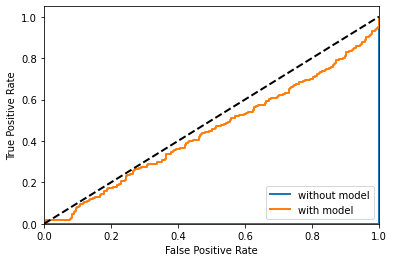

In [7]:
# now bootstrap at the patient level 
labels = ["without model", "with model"] 
for i in [0,1]:
    roc_curves, auc_scores, aupr_scores = [], [], []

    y_true_orig, y_pred_orig = [], []
    for patient in all_patients:
        predictions = patient_to_model_to_prediction[patient]
        for prediction in predictions[i]:
            y_true_orig.append(ground_truth[patient])
            y_pred_orig.append(prediction) 

    fpr, tpr, _ = metrics.roc_curve(y_true_orig, y_pred_orig)

    for j in range(1000): 
        patients = resample(all_patients, replace=True, random_state=1)
    #     get predictions and ground truth: 
        y_true, y_pred = [],[]
        for patient in patients:
            predictions = patient_to_model_to_prediction[patient]
            for prediction in predictions[i]:
                y_true.append(ground_truth[patient])
                y_pred.append(prediction) 
        roc_curve = metrics.roc_curve(y_true, y_pred)
        auc_score = metrics.roc_auc_score(y_true, y_pred)
        auc_scores.append(auc_score)   
        roc_curves.append(roc_curve)




    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for fpr, tpr, _ in roc_curves:
        tprs.append(scipy.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(metrics.auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)

    lw = 2
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.1)
    plt.plot(fpr, tpr, lw=lw, label = labels[i])
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("w_vs_wo_model_auroc.pdf")
plt.show()

No handles with labels found to put in legend.


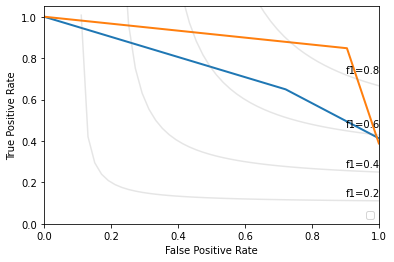

In [114]:
# now bootstrap at the patient level 

labels = ["without model", "with model"] 
for i in [0,1]:
    roc_curves, aupr_scores = [], []

    y_true_orig, y_pred_orig = [], []
    for patient in all_patients:
        predictions = patient_to_model_to_prediction[patient]
        for prediction in predictions[i]:
            y_true_orig.append(ground_truth[patient])
            y_pred_orig.append(prediction) 

    precision, recall, _ = precision_recall_curve(y_true_orig, y_pred_orig)
        
#     for j in range(1000): 
#         patients = resample(all_patients, replace=True, random_state=1)
#     #     get predictions and ground truth: 
#         y_true, y_pred = [],[]
#         for patient in patients:
#             predictions = patient_to_model_to_prediction[patient]
#             for prediction in predictions[i]:
#                 y_true.append(ground_truth[patient])
#                 y_pred.append(prediction) 
#         aupr_scores.append(metrics.auc(*metrics.precision_recall_curve(yte_true_b, yte_pred_b)[1::-1]))


#     tprs = []
#     aucs = []
#     mean_fpr = np.linspace(0, 1, 100)
#     for fpr, tpr, _ in roc_curves:
#         tprs.append(scipy.interp(mean_fpr, fpr, tpr))
#         tprs[-1][0] = 0.0
#         aucs.append(metrics.auc(fpr, tpr))

#     mean_tpr = np.mean(tprs, axis=0)

#     std_tpr = np.std(tprs, axis=0)
#     tprs_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
#     tprs_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)

#     lw = 2
#     plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.1)
#     plt.plot(fpr, tpr, lw=lw, label = labels[i])
    
    plt.plot(recall, precision, lw=2)

    
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        
        

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("w_vs_wo_model_auroc.pdf")
plt.show()

array([1.        , 0.90463918, 0.        ])

In [97]:
# now bootstrap at the patient level 
labels = ["without", "with"] 
for i in [0,1]:
    accuracy_scores = []

    y_true_orig, y_pred_orig = [], []
    for patient in all_patients:
        predictions = patient_to_model_to_prediction[patient]
        for prediction in predictions[i]:
            y_true_orig.append(ground_truth[patient])
            y_pred_orig.append(prediction) 

    orig_accuracy = metrics.accuracy_score(y_true_orig, y_pred_orig)
    for j in range(1000): 
        patients = resample(all_patients, replace=True, random_state=1)
    #     get predictions and ground truth: 
        y_true, y_pred = [],[]
        for patient in patients:
            predictions = patient_to_model_to_prediction[patient]
            for prediction in predictions[i]:
                y_true.append(ground_truth[patient])
                y_pred.append(prediction) 
        accuracy_scores.append(metrics.accuracy_score(y_true, y_pred))   

        
    conf_int = ' ({:.2f}-{:.2f})'.format(np.percentile(accuracy_scores, 2.5), np.percentile(accuracy_scores, 97.5))
    print(" model:", orig_accuracy, conf_int)
    


 model: 0.805  (0.80-0.80)
 model: 0.85  (0.85-0.85)
